In [1]:
import numpy as np
from torch.autograd import Variable
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data_utils
import math
import torchvision.models as models
from PIL import Image
import os

In [2]:
def deepfool(image, net, num_classes=10, overshoot=0.2, max_iter=50):
  is_cuda = torch.cuda.is_available()

  if is_cuda:
    print("Using GPU")
    image = image.cuda()
    net = net.cuda()
  else:
    print("Using CPU")
  
  f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
  I = (np.array(f_image)).flatten().argsort()[::-1]

  I = I[0:num_classes]
  label = I[0]

  input_shape = image.cpu().numpy().shape
  pert_image = copy.deepcopy(image) 
  w = np.zeros(input_shape)
  r_tot = np.zeros(input_shape)

  loop_i = 0

  x = Variable(pert_image[None, :], requires_grad=True)
  fs = net.forward(x)
  fs_list = [fs[0, I[k]] for k in range(num_classes)]
  k_i = label

  while k_i == label and loop_i < max_iter:
    pert = np.inf
    fs[0, I[0]].backward(retain_graph=True)
    grad_orig = x.grad.data.cpu().numpy().copy()

    for k in range(1, num_classes):
      x.grad.zero_()

      fs[0, I[k]].backward(retain_graph=True)
      cur_grad = x.grad.data.cpu().numpy().copy()

      w_k = cur_grad - grad_orig
      f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

      pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

      if pert_k < pert:
        pert = pert_k
        w = w_k
      
    r_i = (pert+1e-4) * w / np.linalg.norm(w)
    r_tot = np.float32(r_tot + r_i)

    if is_cuda:
      pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
    else:
      pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

    x = Variable(pert_image, requires_grad=True)
    fs = net.forward(x)
    k_i = np.argmax(fs.data.cpu().numpy().flatten())

    loop_i += 1
  
  r_tot = (1+overshoot)*r_tot

  return r_tot, loop_i, label, k_i, pert_image

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Using GPU
Original label =  n01818515 macaw
Perturbed label =  n02007558 flamingo


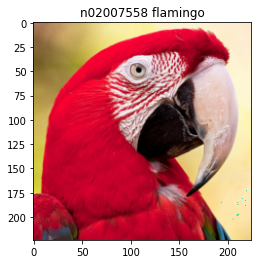

In [3]:
net = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

net.eval()

im_orig = Image.open("data/test_im1.jpg")

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

im = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])(im_orig)

r, loop_i, label_orig, label_pert, pert_image = deepfool(im, net)

labels = open(os.path.join("data/sysnet_words.txt"), 'r').read().split('\n')

str_label_orig = labels[int(label_orig)].split(',')[0]
str_label_pert = labels[int(label_pert)].split(',')[0]

print("Original label = ", str_label_orig)
print("Perturbed label = ", str_label_pert)

def clip_tensor(A, minv, maxv):
  A = torch.max(A, minv*torch.ones(A.shape))
  A = torch.min(A, maxv*torch.ones(A.shape))
  return A

clip = lambda x: clip_tensor(x, 0, 255)

tf = transforms.Compose([
    transforms.Normalize(mean=[0,0,0], std=list(map(lambda x: 1/x, std))),
    transforms.Normalize(mean=list(map(lambda x: -x, mean)), std=[1,1,1]),
    transforms.Lambda(clip),
    transforms.ToPILImage(),
    transforms.CenterCrop(224)
])

plt.figure()
plt.imshow(tf(pert_image.cpu()[0]))
plt.title(str_label_pert)
plt.show()

Using GPU
Original label =  n03538406 horse cart
Perturbed label =  n02437312 Arabian camel


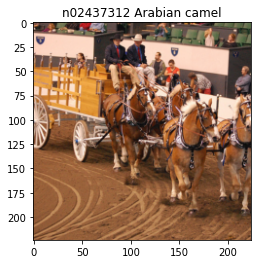

In [4]:
net = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

net.eval()

im_orig = Image.open("data/test_im2.jpg")

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

im = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])(im_orig)

r, loop_i, label_orig, label_pert, pert_image = deepfool(im, net)

labels = open(os.path.join("data/sysnet_words.txt"), 'r').read().split('\n')

str_label_orig = labels[int(label_orig)].split(',')[0]
str_label_pert = labels[int(label_pert)].split(',')[0]

print("Original label = ", str_label_orig)
print("Perturbed label = ", str_label_pert)

def clip_tensor(A, minv, maxv):
  A = torch.max(A, minv*torch.ones(A.shape))
  A = torch.min(A, maxv*torch.ones(A.shape))
  return A

clip = lambda x: clip_tensor(x, 0, 255)

tf = transforms.Compose([
    transforms.Normalize(mean=[0,0,0], std=list(map(lambda x: 1/x, std))),
    transforms.Normalize(mean=list(map(lambda x: -x, mean)), std=[1,1,1]),
    transforms.Lambda(clip),
    transforms.ToPILImage(),
    transforms.CenterCrop(224)
])

plt.figure()
plt.imshow(tf(pert_image.cpu()[0]))
plt.title(str_label_pert)
plt.show()